In [2]:
from google.colab import drive
import os

# set path to project folder
gdrive_path='/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/' # Luca's Path
#gdrive_path='/content/gdrive/MyDrive/Uni/adl4vc/nerf_segmentation/' # Luis' Path

# mount Google Drive
drive.mount('/content/gdrive', force_remount=True)

# navigate to Google Drive folder
os.chdir(gdrive_path)

# check that we are in the right folder
print(sorted(os.listdir()))

Mounted at /content/gdrive
['.git', 'README.md', 'data', 'data_loader.ipynb', 'data_loading', 'example_arrows', 'gaussian_splatting.ipynb', 'gitignore', 'gs_intro.ipynb', 'open_nerf.ipynb', 'outputs', 'visual_data.ipynb']


# Gaussian Splatting

## Setup

We will use `nerfstudio` to train, run, and visualize our results. Make sure to have the following repository structure established:
```
adl4vc  
|_ nerf_segmentation  
    |_ data  
        |_ lerf  
        |_ replica  
|_ opennerf
```

Let's start with some general dependencies such as `tinycuda`, `colmap`, and `torch`.

In [3]:
!python -m pip install --upgrade pip
!python -m pip install pytorch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 pytorch-cuda=12.1 -c pytorch -c nvidia
!python -m pip install ninja git+https://github.com/NVlabs/tiny-cuda-nn/#subdirectory=bindings/torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'
  Cloning https://github.com/NVlabs/tiny-cuda-nn/ to /tmp/pip-req-build-l874fs4h
  Running command git clone --filter=blob:none --quiet https://github.com/NVlabs/tiny-cuda-nn/ /tmp/pip-req-build-l874fs4h
  Resolved https://github.com/NVlabs/tiny-cuda-nn/ to commit 2ec562e853e6f482b5d09168705205f46358fb39
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.8 MB/s eta 0:00:00
  Created wheel for tinycudann: filename=tinycudann-1.7-cp310-cp310-linux_x86_64.whl size=30358239 sha256=01e52b937a522df626bc307fbc6fe4c6d73ac065ec663e0146970262a3664262
  Stored in directory: /tmp/pip

In [4]:
!pip install tensorflow-gpu==2.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 44.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: 

In [5]:
!python -m pip install nerfstudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of imageio to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of nuscenes-devkit to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.2/570.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

Once we have installed all required dependencies, we can make use of `nerfstudio`'s implementation of Gaussian Splatting. It is called `splatfacto` to delineate from the original Gaussian Splatting paper. Let's start by training it scenes from Replica! With a T4-GPU, this will take ~35min for a single scene.

## Run Training

In [29]:
!ns-train nerfacto --viewer.make-share-url True --data /content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/data/nerfstudio_/replica_office0

Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1006, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 688, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/usr/local/lib/python3.10/dist-packages/torchgen/model.py", line 1698, in <module>
    class Annotation:
  File "/usr/lib/python3.10/dataclasses.py", line 1175, in wrap
    return _process_class(cls, init, repr, eq, order, unsafe_hash,
  File "/usr/lib/python3.10/dataclasses.py", line 1044, in _process_class
    _set_new_attribute(cls, '__repr__', _repr_fn(flds, globals))
  File "/usr/lib/python3.10/dataclasses.py", line 588, in _repr_fn
    fn = _create_fn('__repr__',
  File "/usr/lib/python3.10/dataclasses.py", line 432, in _create_fn
    exec(txt, globals, ns)
  File "<string>", 

## Export Results

In [ ]:
!ns-export gaussian-splat --load-config /content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfacto/2024-05-13_211923/config.yml --output-dir /content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfacto/2024-05-12_211923/

2024-05-13 20:34:16.134451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2024-05-13 20:34:16.134497: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[20:34:29] Auto image downscale factor of 1                                                 ]8;id=912482;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py\nerfstudio_dataparser.py]8;;\:]8;id=70015;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/data/dataparsers/nerfstudio_dataparser.py#484\484]8;;\
Traceback (most recent call last):
  File "/usr/local/bin/ns-export", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/d

[Open3D WARNING] Read PLY failed: unable to open file: /content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfactor/2024-05-13_211923/splat.ply


RPly: Unable to open file


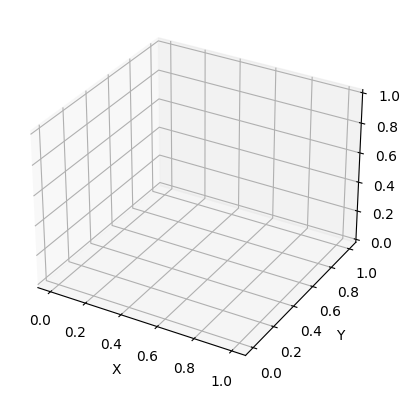

In [3]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the .ply file
ply_file_path = '/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfactor/2024-05-13_211923/splat.ply'
pcd = o3d.io.read_point_cloud(ply_file_path)

# Convert the point cloud to a numpy array
points = np.asarray(pcd.points)

# Plot the point cloud using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='b', marker='o')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [5]:
import os

# Verify if the file path exists
ply_file_path = '/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfacto/2024-05-13_211923/splat.ply'
if os.path.exists(ply_file_path):
    print("File exists.")
else:
    print("File does not exist.")

# List all files in the directory to confirm the file name and path
directory_path = os.path.dirname(ply_file_path)
files = os.listdir(directory_path)
print("Files in the directory:", files)


File exists.
Files in the directory: ['config.yml', 'dataparser_transforms.json', 'nerfstudio_models', 'splat.ply']


## Understanding the PLY File Format from NeRFStudio

This documentation explains the structure and properties of the PLY file generated using NeRFStudio's `ns-export splatfacto` function. This PLY file represents a 3D point cloud derived from a Neural Radiance Field (NeRF).

The primary element in the PLY file is `vertex`, which defines each point in the point cloud. Each vertex has several properties associated with it:

### Spatial Properties

- `x`, `y`, `z`: Coordinates of the vertex in 3D space.
- `nx`, `ny`, `nz`: Components of the normal vector, indicating the surface orientation at the vertex.

### Color Properties

- `f_dc_0`, `f_dc_1`, `f_dc_2`: Diffuse color components of the vertex, likely in RGB format.
  - `f_dc_0`: Red component
  - `f_dc_1`: Green component
  - `f_dc_2`: Blue component

### Additional Feature Properties

- `f_rest_0` to `f_rest_44`: Additional feature vectors associated with each point. These features are learned by the NeRF model and help in synthesizing the scene's appearance and geometry.

### Opacity

- `opacity`: Represents the transparency of the vertex, with values ranging from 0 (completely transparent) to 1 (completely opaque).

### Transformation Properties

- `scale_0`, `scale_1`, `scale_2`: Scaling factors for the vertex in the x, y, and z dimensions, respectively. These adjust the size of the Gaussian splats.
- `rot_0`, `rot_1`, `rot_2`, `rot_3`: Components of a quaternion representing the rotation of the vertex in 3D space.



In [11]:
!python -m pip install plyfile

In [28]:
import os
import pandas as pd
from plyfile import PlyData
import torch
from IPython.display import display

# Specify the path to your .ply file
ply_file_path = '/content/gdrive/MyDrive/1-university/masters/2-semester/in2390_adl4cv/nerf_segmentation/outputs/replica_office0/splatfacto/2024-05-13_211923/splat.ply'

# Verify if the file exists before trying to read it
if os.path.exists(ply_file_path):
    # Load the .ply file
    ply_data = PlyData.read(ply_file_path)

    # Extract the vertex data
    vertex_data = ply_data['vertex']
    vertex_df = pd.DataFrame(vertex_data.data)

    # Display the dataframe to verify
    display(vertex_df.head())

    # Convert DataFrame to numpy array for processing
    features = vertex_df.values

    # Normalize the features
    features_mean = features.mean(axis=0)
    features_std = features.std(axis=0)

    # Add a small epsilon value to std to avoid division by zero
    epsilon = 1e-8
    normalized_features = (features - features_mean) / (features_std + epsilon)

    # Convert normalized features to a PyTorch tensor
    input_tensor = torch.tensor(normalized_features, dtype=torch.float32)

    # Print the shape of the tensor to verify
    print("Shape of input tensor:", input_tensor.shape)
else:
    print("The file does not exist. Please check the file path.")

,x,y,z,nx,ny,nz,f_dc_0,f_dc_1,f_dc_2,f_rest_0,...,f_rest_43,f_rest_44,opacity,scale_0,scale_1,scale_2,rot_0,rot_1,rot_2,rot_3
0,-0.586364,-2.030792,3.316855,0.0,0.0,0.0,0.178468,0.896800,0.374212,0.0,...,0.0,0.0,-2.197225,-1.516485,-1.516485,-1.516485,0.535505,0.774932,-0.335693,-0.005054
1,4.515545,-4.247341,3.860137,0.0,0.0,0.0,0.933382,0.969690,0.122286,0.0,...,0.0,0.0,-2.197225,-2.101660,-2.101660,-2.101660,0.141955,-0.303761,0.450463,-0.827442
2,0.832096,-1.623523,3.089750,0.0,0.0,0.0,0.192759,0.674811,0.188885,0.0,...,0.0,0.0,-2.197225,-1.612986,-1.612986,-1.612986,0.728750,0.617235,-0.277117,0.105590
3,-1.931803,-3.835114,4.102695,0.0,0.0,0.0,0.437477,0.355583,0.922609,0.0,...,0.0,0.0,-2.197225,-1.533376,-1.533376,-1.533376,0.117810,0.863854,-0.471031,0.134190
4,-3.911819,-3.363445,2.025201,0.0,0.0,0.0,0.137895,0.040298,0.812131,0.0,...,0.0,0.0,-2.197225,-1.831025,-1.831025,-1.831025,-0.255625,0.246248,-0.402120,-0.843989


Shape of input tensor: torch.Size([149588, 62])
